<a href="https://colab.research.google.com/github/hellum55/ML2/blob/main/Exam%202024/Part%202/Deep_Learning_predict_waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First load desired packages. Then load from the downloaded zip file

In [2]:
from google.colab import drive
import zipfile
import os
from PIL import Image
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory


Q. a)
Inspect the images for noise, ambiguous features, and rare features. Plot as many as you need
to familiarize yourself with the data. CH5 is helpful here.

In [3]:
train_dataset = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/data_waste/realwaste-main/RealWaste',
    image_size=(224, 224),
    batch_size=32,
    seed = 123,
    validation_split = 0.2,
    subset = 'training')
validation_dataset = image_dataset_from_directory(
    directory = '/content/drive/MyDrive/Colab Notebooks/data_waste/realwaste-main/RealWaste',
    image_size=(224, 224),
    batch_size=32,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation')

Found 4750 files belonging to 9 classes.
Using 3800 files for training.
Found 4750 files belonging to 9 classes.
Using 950 files for validation.


In [4]:
data_iterator = train_dataset.as_numpy_iterator()

In [5]:
batch = data_iterator.next()

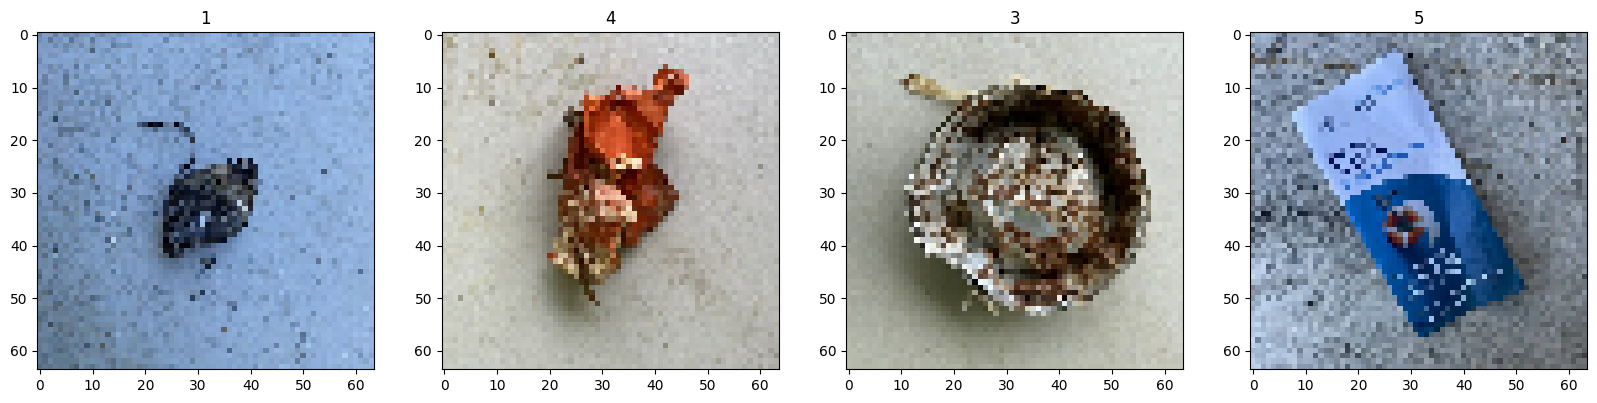

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
batch[0].shape

(64, 64, 64, 3)

The images that a represented as numpy arrays. 32 batches, the image shape is 524x524 and there are three layers wich means it is color images.

The above code will show a couple of the pictures from the training set and validation set. It must be assumed that some of the pictures are either mislabelled or very hard to categorize because of the picture. We are dealing with trash, which means some of the data must be noisy at some point. Some bad data might first be shown when we have classified the validation set. I am not running trough 400o different pictures of trash :)

Lets have a look on the distributions of the different classes, to have a sense on whether it is balanced or not.

Q. b) Focus on what you would need to know to replicate
their approach. For instance: Which models do they train? What’s the learning rate? Which kind of data augmentation do they use? How well do their models perform?


The paper provided they are using different popular CNN models such as VGG-16, DenseNet121, Inception V3, InceptionsResNet V2, and MobileNetV2. The learning rates to each of the models are provided in the table and given as 1 × 10−5. Each model is selected for its unique architectural characteristics, such as shallow design, increased layer depth, lightweight design, or a combination of techniques.

Two sets of augmentations are selected and applied to each image, respectively, tripling the total number of images within each training dataset.
Augmentation methods include a combination of geometric transformations such as horizontal flipping, rotation, elastic distortion, and shear.

Model performance is evaluated based on metrics such as accuracy, precision, recall, and F1-score. Inception V3 achieved the highest classification accuracy of 89.19% when trained on RealWaste, with notable precision, recall, and F1-score. Models like VGG-16 performed relatively poorly, indicating the importance of architectural characteristics such as depth and complexity for accurate waste classification.


Q. c)
Go through as many points on the universal workflow of machine learning in CH6 as you find
relevant (e.g., skip deployment, i.e., CH6.3). Use the same training/validation procedure and
split as in Single et al. (2023), but do not make a separate test set. A separate test set will be
provided at the exam.

1) Frame the problem: The main objective is to classify trash with CNN models as accurate as possible. A task that is highly relevant in todays society where trash needs to be classified correctly to be reused again.

2) Beware of non-representative data: There might be a problem with the data labels, because there are only 9 classes. In reality there might be very many different classes. The model can only classify the images correctly if it has seen the objects before.

3) class imbalance: The data is imbalanced there are not equal amount of features in each of the classes.

4) The metric we are measurering upon is both accuracy and the loss. The loss function is better because it heavily penalizes the wrong predictions, where accuracy is a question of how well the model can predict the majority class.

5) It is a softmax last-layer activation function because it is a multiclass problem.

6) The data is already split with keras.

In [8]:
#The max wihtin the batch is 255. Therefore we need to divide them all by 255 so it becomes a scale from 0-1
scaled = batch[0]/255

In [9]:
scaled.max()

1.0

In [ ]:
#This can be done like this, so we dont have to do it for every batch within a function
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
#Lets have a look on our next batch. It looks like what we expected. (0-1)
train_dataset.as_numpy_iterator().next()

(array([[[[0.42352945, 0.49803925, 0.6156863 ],
          [0.427451  , 0.5019608 , 0.61960787],
          [0.427451  , 0.5019608 , 0.61960787],
          ...,
          [0.36862746, 0.43137258, 0.48235297],
          [0.37647063, 0.4431373 , 0.48235297],
          [0.3803922 , 0.44705886, 0.48627454]],
 
         [[0.42352945, 0.49803925, 0.6156863 ],
          [0.427451  , 0.5019608 , 0.61960787],
          [0.427451  , 0.5019608 , 0.61960787],
          ...,
          [0.3803922 , 0.4431373 , 0.49411768],
          [0.3803922 , 0.44705886, 0.48627454],
          [0.3803922 , 0.44705886, 0.48627454]],
 
         [[0.43137258, 0.5058824 , 0.62352943],
          [0.427451  , 0.5019608 , 0.61960787],
          [0.41960788, 0.49411768, 0.6117647 ],
          ...,
          [0.37647063, 0.4431373 , 0.48235297],
          [0.37647063, 0.4431373 , 0.48235297],
          [0.37254903, 0.43921572, 0.4784314 ]],
 
         ...,
 
         [[0.5882353 , 0.68235296, 0.79215693],
          [0.58431

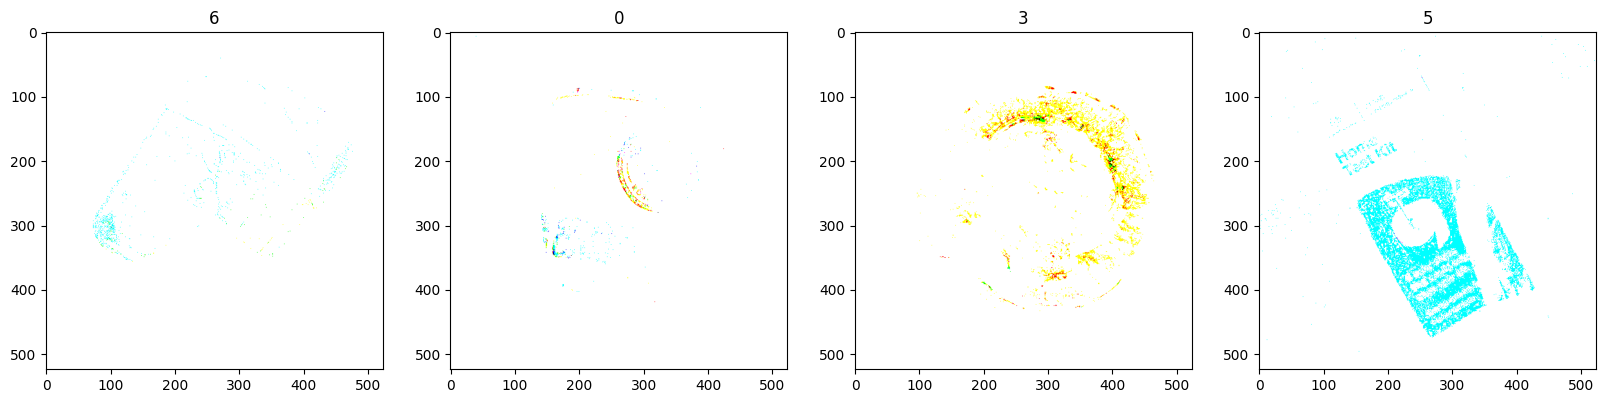

In [ ]:
#This is our images now when scaled:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
#number of batches in training set and validation set
print(len(train_dataset))
print(len(validation_dataset))

60
15


As our first model we apply the sequential method. The input shape is the shape of the images we saw from earlier. We first add a convolution to our model which has 32 filters, that scans the image and extract the relevant information. The filter will have 3x3 pixels in size, and a stride of 1, which means it will move the filter 1 pixel at a time. The activation function is the relu function. We are taking the output of that conv-layer and pass it into the relu function. Because of the relu-architecture we convert all negative outputs to zero.

Then we are applying a max pooling layer. It takes the maximun value after the relu-activation and return back that value. The pool-size is 2x2, which will cut the image data by half.

That continues until the flatten() function.

The dense layers says we have 128 neurons

In [4]:
from tensorflow.keras import layers
data_augmentation = tf.keras.Sequential([
layers.RandomFlip("horizontal_and_vertical"),
layers.RandomRotation(0.2),
])

In [10]:
from tensorflow import keras

inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1/255)(inputs)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(64, activation="relu")(x)

x = layers.Dropout(0.2)(x)

x = layers.Dense(32, activation="relu")(x)

outputs = layers.Dense(9, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                      

In [12]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset)

Epoch 1/30
119/119 [==============================] - 29s 204ms/step - loss: 2.1279 - accuracy: 0.1905 - val_loss: 1.9024 - val_accuracy: 0.2389
Epoch 2/30
119/119 [==============================] - 26s 207ms/step - loss: 1.8537 - accuracy: 0.3087 - val_loss: 1.8136 - val_accuracy: 0.3747
Epoch 3/30
119/119 [==============================] - 25s 198ms/step - loss: 1.6751 - accuracy: 0.3839 - val_loss: 1.5164 - val_accuracy: 0.4432
Epoch 4/30
119/119 [==============================] - 24s 197ms/step - loss: 1.5248 - accuracy: 0.4242 - val_loss: 1.4257 - val_accuracy: 0.4842
Epoch 5/30
119/119 [==============================] - 25s 200ms/step - loss: 1.4455 - accuracy: 0.4595 - val_loss: 1.3804 - val_accuracy: 0.4758
Epoch 6/30
119/119 [==============================] - 24s 195ms/step - loss: 1.3581 - accuracy: 0.4871 - val_loss: 1.3123 - val_accuracy: 0.5284
Epoch 7/30
119/119 [==============================] - 25s 199ms/step - loss: 1.2587 - accuracy: 0.5171 - val_loss: 1.2366 - val_ac

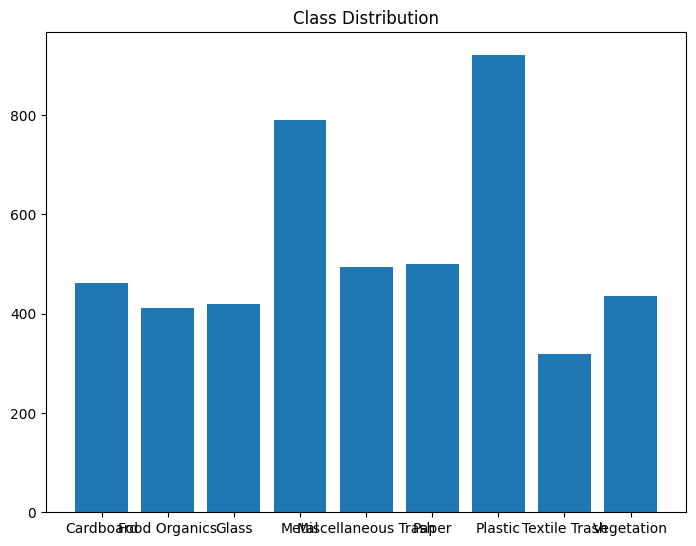

In [ ]:
# display class distribution
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [461,411,420,790,495,500,921,318,436]
ax.bar(dataset.classes, counts)
plt.title('Class Distribution')
plt.show()

Split the data into train and validation sets. Test set will be provided at the exam.